<a href="https://colab.research.google.com/github/Alex-Chen1121/Machine-learning/blob/main/Kaggle%E8%B3%87%E6%96%99%E9%9B%86_Retinopathy_classificationV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip
!unzip -q retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
From (redirected): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7&confirm=t&uuid=270b3a41-708a-454f-a50f-036ad39177e7
To: /content/retina-dataset.zip
100% 622M/622M [00:16<00:00, 37.6MB/s]


In [2]:
!gdown --id "16I0VF3o270kr6EbbOTHG0G62nFG281Go" --output model.pth

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=16I0VF3o270kr6EbbOTHG0G62nFG281Go 



In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
# Define Parameters
NUM_CLASS = 5 # 分五類
IMG_SIZE = 224 # 定義圖片大小
BS = 64
# 確定運算裝置
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Data Visualization

In [5]:
# 答案(每個圖片的診斷類別)
df = pd.read_csv("kaggle_retina/train.csv")
df.head(7)

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0
5,674057ab250c,2
6,59e5212f7139,1


In [6]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

In [7]:
path = glob("kaggle_retina/train/*.png")
path_test = glob("kaggle_retina/test/*.png")

# 看資料筆數各是多少
len(path), len(path_test)

(2197, 1465)

In [8]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
filename
path = f"kaggle_retina/train/{filename}.png"
path
img = cv2.imread(path)[:,:,::-1]
# plt.imshow(img)
# print(path)
# print(f'label: {row["diagnosis"]}')

第631張
檔名: 1d37f1c8b6d8
類別: 0


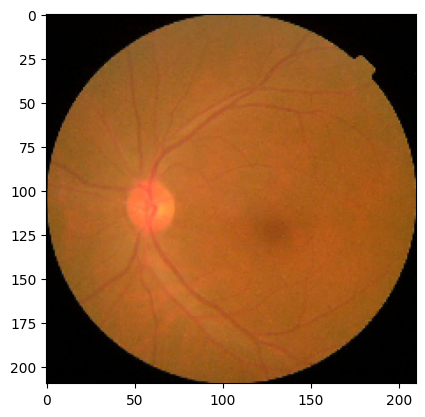

In [9]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row[0]

cls = row[1]
path = f"kaggle_retina/train/{filename}.png"
path
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(f"第{idx}張")
print("檔名:",filename)
print("類別:",cls)

In [10]:
# 將所有診斷結果存成1D的列表當答案
all_cls = df['diagnosis'].tolist()
# 秀出前三筆
print(all_cls[:3])

[1, 4, 0]


[0 1 2 3 4]
[1083  222  599  116  177]


<BarContainer object of 5 artists>

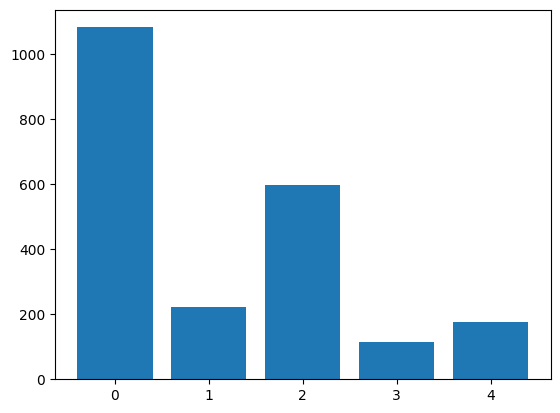

In [11]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
print(cls)
print(count)
plt.bar(cls, count)

#### Dataset, DataLoader

In [12]:
import imgaug.augmenters as iaa
import imgaug as ia

class RetinaDataset(torch.utils.data.Dataset):
    def __init__(self, df, aug, img_size=224):
        self.df = df
        self.transform = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.Affine(
                rotate=(-45, 45),
                shear=(-16,16),
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
            ),
        ])
        self.aug = aug
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png"
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (self.img_size, self.img_size))
        if self.aug:
            img = self.transform.augment_image(image=img)
        img = img / 255.
        label = row["diagnosis"]

        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [13]:
df = pd.read_csv("kaggle_retina/train.csv")
train_df, val_df = train_test_split(df,
                                    test_size=0.2, # 82分
                                    random_state=5566) # 固定資料

In [14]:
df = pd.read_csv("kaggle_retina/train.csv")

train_df, val_df = train_test_split(df, test_size=0.2 )

In [15]:
train_ds = RetinaDataset(train_df, aug=True, img_size=IMG_SIZE) # 資料集轉換
val_ds = RetinaDataset(val_df, aug=False, img_size=IMG_SIZE)

817 tensor(1)


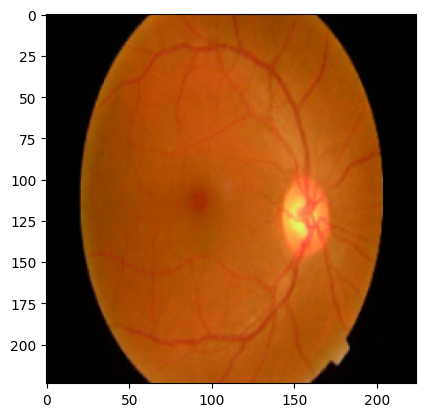

In [16]:
idx = np.random.randint(0, len(train_ds))
# 圖片 , 標記
img, label = train_ds[idx]
print(idx, label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [17]:
print(img.shape)

torch.Size([3, 224, 224])


In [18]:
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True) # torch 只支援一個batch的資料批次訓練
val_loader = torch.utils.data.DataLoader(val_ds, BS)

#### [TODO] Model

In [19]:
class ConvBn(nn.Module):
  def __init__(self, cin, cout):
      super().__init__()
      self.conv = nn.Conv2d(cin, cout, kernel_size=3, padding='same')
      self.bn = nn.BatchNorm2d(num_features=cout)
      self.act = nn.ReLU()
  def forward(self, x):
      x = self.conv(x)
      x = self.bn(x)
      return self.act(x)


class CNN(nn.Module):
  def __init__(self, kernal_size = 3):
      super().__init__()
      self.encoder = nn.Sequential(
          ConvBn(3,16),
          ConvBn(16,16),
          nn.MaxPool2d(kernel_size=2),
          ConvBn(16,32),
          ConvBn(32,32),
          nn.MaxPool2d(kernel_size=2),
          ConvBn(32,64),
          ConvBn(64,64),
          nn.MaxPool2d(kernel_size=2),

      )
      self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
      )
      self.classifier = nn.Sequential(
          nn.Dropout(0.3),
          nn.Linear(64, 256),
          nn.Dropout(0.3),
          nn.Linear(256, 5)
      )
  def forward(self, x):
    x = self.encoder(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x

In [20]:
model = CNN(kernal_size = 7).to(device)

In [21]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            ConvBn-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           2,320
       BatchNorm2d-6         [-1, 16, 224, 224]              32
              ReLU-7         [-1, 16, 224, 224]               0
            ConvBn-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           ConvBn-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

#### Training

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [25]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.2518, train_acc: 0.516     val_loss: 1.7915, val_acc: 0.289 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.0782, train_acc: 0.617     val_loss: 1.0936, val_acc: 0.595 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.0069, train_acc: 0.627     val_loss: 1.0656, val_acc: 0.611 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.9585, train_acc: 0.651     val_loss: 0.8846, val_acc: 0.682 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.9289, train_acc: 0.670     val_loss: 1.0118, val_acc: 0.641 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.9245, train_acc: 0.686     val_loss: 1.8752, val_acc: 0.377 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.8865, train_acc: 0.686     val_loss: 1.2514, val_acc: 0.616 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.8984, train_acc: 0.675     val_loss: 0.9399, val_acc: 0.686 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.9123, train_acc: 0.672     val_loss: 1.4062, val_acc: 0.561 
Earlystop!


#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [26]:
model.load_state_dict(torch.load('best.pth'))
_ = model.eval().to(device)

In [27]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_size=224):
        self.df = df
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, IMG_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [28]:
# Inference
y_pred = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

In [29]:
# 轉成csv檔案提交
df['diagnosis'] = y_pred
df.to_csv('submission.csv', index=None)